# **v3.0 GraphSAGE Architecture with MLP**

nodes: nodecount2km SUM

edges: integration2km

In [50]:
import os

#giving the directory of the files
path = "C:/Users/chalm/Documents/Sem 2/Computational Intelligence/SpaceSyntax_UK/" # Corrected path to the directory
# using chdir for changing the directory to the path we look for
os.chdir(path)

## **1. Loading dataset**

Converting road network to:
 - Nodes: Start/End coords of LINESTRING geometry
 - Edges: LINESTRING geometry

In [51]:

import pandas as pd
import re

#reading a comma-separated values (csv) file into DataFrame
df = pd.read_csv("Birmingham.csv")

# Load your dataset
df = pd.read_csv("Birmingham.csv")  # adjust path as needed

# Function to extract coordinate pairs from WKT LINESTRING
def extract_coords(linestring):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", linestring)
    coords = list(map(float, coords))
    return (coords[0], coords[1]), (coords[2], coords[3])  # (x1, y1), (x2, y2)

# Apply extraction to geometry column
df['source_coords'], df['target_coords'] = zip(*df['geometry'].apply(extract_coords))

# Preview the new columns
df[['geometry', 'source_coords', 'target_coords']].head()


,geometry,source_coords,target_coords
0,"LINESTRING (399984 281923, 399953 281943)","(399984.0, 281923.0)","(399953.0, 281943.0)"
1,"LINESTRING (399953 281943, 399990 281940)","(399953.0, 281943.0)","(399990.0, 281940.0)"
2,"LINESTRING (399870 277371, 399848 277354)","(399870.0, 277371.0)","(399848.0, 277354.0)"
3,"LINESTRING (400343 277539, 400796 277452)","(400343.0, 277539.0)","(400796.0, 277452.0)"
4,"LINESTRING (400173 277544, 400271 277545)","(400173.0, 277544.0)","(400271.0, 277545.0)"


In [52]:
# Step 1: Get all unique coordinates
all_coords = pd.concat([df['source_coords'], df['target_coords']])
unique_coords = pd.Series(all_coords.unique())

# Step 2: Create a mapping from coordinate → node ID
coord_to_id = {coord: idx for idx, coord in enumerate(unique_coords)}

# Step 3: Map source/target coords to node IDs
df['source_id'] = df['source_coords'].map(coord_to_id)
df['target_id'] = df['target_coords'].map(coord_to_id)

# Step 4: Build the edge list
edge_index = df[['source_id', 'target_id']].values.T  # shape [2, num_edges]

# Optional: Confirm number of unique nodes and edges
num_nodes = len(unique_coords)
num_edges = edge_index.shape[1]

print(f"Graph has {num_nodes} nodes and {num_edges} edges")


Graph has 12509 nodes and 16192 edges


## **2. Correlation Matrix**

To determine appropriate node features for training

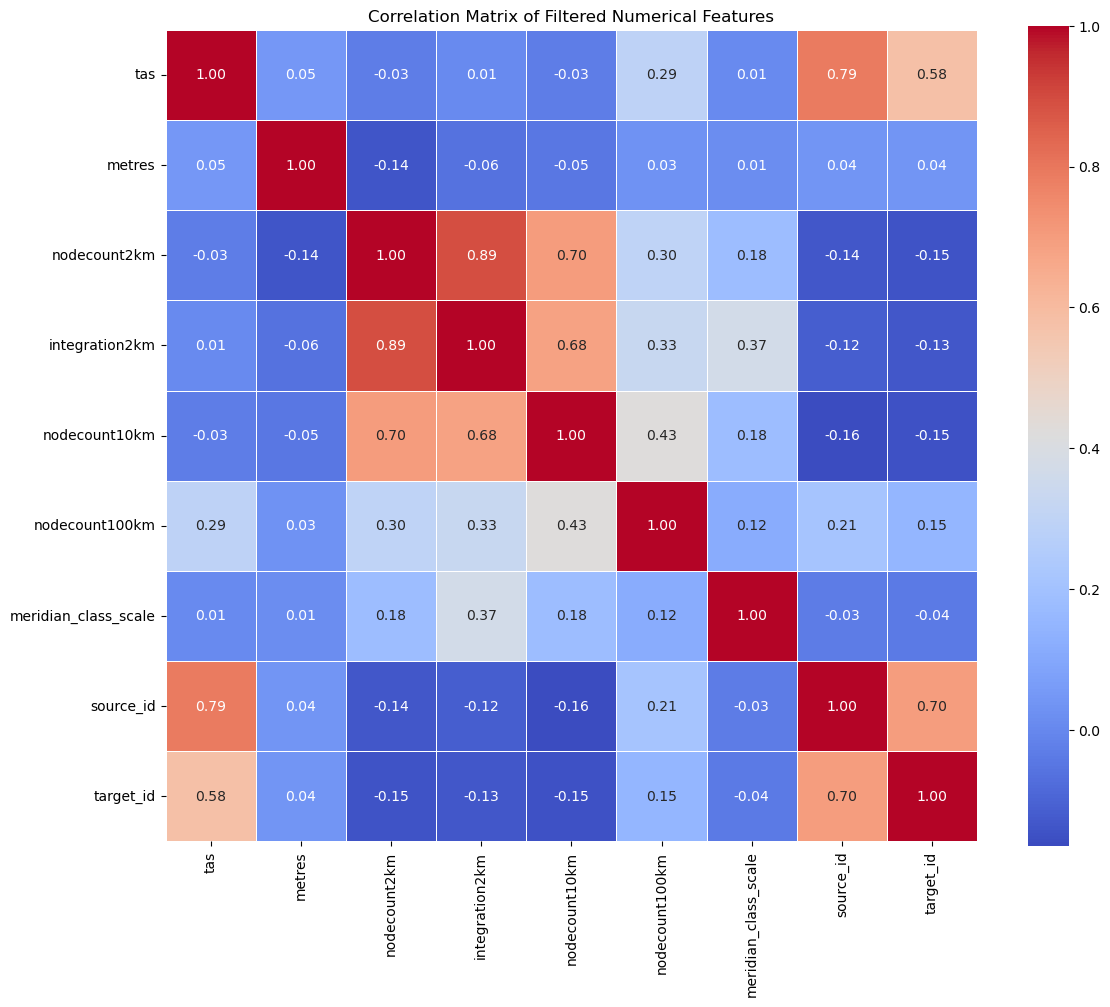

,tas,metres,nodecount2km,integration2km,nodecount10km,nodecount100km,meridian_class_scale,source_id,target_id
tas,1.000000,0.046539,-0.030501,0.005576,-0.031885,0.294843,0.007745,0.789200,0.580800
metres,0.046539,1.000000,-0.138403,-0.063320,-0.046519,0.027709,0.014344,0.039373,0.038509
nodecount2km,-0.030501,-0.138403,1.000000,0.894424,0.702034,0.299186,0.178586,-0.135975,-0.145382
integration2km,0.005576,-0.063320,0.894424,1.000000,0.684134,0.330244,0.368816,-0.116202,-0.134737
nodecount10km,-0.031885,-0.046519,0.702034,0.684134,1.000000,0.425261,0.178674,-0.163784,-0.148512
nodecount100km,0.294843,0.027709,0.299186,0.330244,0.425261,1.000000,0.117846,0.209252,0.150064
meridian_class_scale,0.007745,0.014344,0.178586,0.368816,0.178674,0.117846,1.000000,-0.033591,-0.037732
source_id,0.789200,0.039373,-0.135975,-0.116202,-0.163784,0.209252,-0.033591,1.000000,0.696036
target_id,0.580800,0.038509,-0.145382,-0.134737,-0.148512,0.150064,-0.037732,0.696036,1.000000


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the columns that are disallowed (choice*, integration100km, etc.)
excluded_keywords = ['choice', 'integration100km', 'integration10km', 'rank']
columns_to_include = [col for col in df.columns if not any(key in col.lower() for key in excluded_keywords)]

# Filter dataframe
filtered_df = df[columns_to_include]

# Select only numerical columns
numerical_df = filtered_df.select_dtypes(include='number')

# Compute full correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Filtered Numerical Features')
plt.tight_layout()
plt.show()

# Optional: display the correlation matrix directly
correlation_matrix

nodecount2km identified as highest correlation of 0.89. To be embedded into the node features (for graphSAGE learning) as it requires node features to understand the graph network. We define the node feature as a SUM of the nodecount2km values of all the edges connected to it.

In [54]:
import torch
import numpy as np

# Initialize node features (1D vector, one value per node)
node_features = np.zeros(num_nodes)

# Add nodecount2km to both source and target nodes
for _, row in df.iterrows():
    src = row['source_id']
    tgt = row['target_id']
    val = row['nodecount2km']
    node_features[src] += val
    node_features[tgt] += val

# Convert to PyTorch tensor and reshape to [num_nodes, 1]
x = torch.tensor(node_features, dtype=torch.float).unsqueeze(1)

print("Node feature tensor shape:", x.shape)  # Should be [num_nodes, 1]


Node feature tensor shape: torch.Size([12509, 1])


In [55]:
from torch_geometric.data import Data

# Ensure edge_index is a PyTorch LongTensor of shape [2, num_edges]
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Now create the PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[12509, 1], edge_index=[2, 16192])


## **3. Build the GraphSAGE model + MLP edge weight predictor**

In [57]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class GraphSAGEEdgePredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        # GraphSAGE layers
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)

        # MLP regressor for edge prediction
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_pairs):
        # Get node embeddings
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = self.sage2(h, edge_index)

        # Extract h_u and h_v for all edges
        h_u = h[edge_pairs[0]]
        h_v = h[edge_pairs[1]]

        # Concatenate and predict
        edge_repr = torch.cat([h_u, h_v], dim=1)
        return self.mlp(edge_repr).squeeze()  # Output shape: [num_edges]


## **4. train-test split**

In [79]:
edge_idx = df[['source_id', 'target_id']].values
edge_labels = df['integration2km'].values

In [75]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Split edge indices and labels into train/test sets (80/20)
train_idx, test_idx = train_test_split(
    np.arange(len(edge_idx)), test_size=0.2, random_state=42
)

# Convert to tensors
edge_pairs = torch.tensor(edge_idx.T, dtype=torch.long)
y = torch.tensor(edge_labels, dtype=torch.float)

train_edge_pairs = edge_pairs[:, train_idx]
train_y = y[train_idx]

test_edge_pairs = edge_pairs[:, test_idx]
test_y = y[test_idx]


## **5. Training loop + Loss function**

In [80]:
# Initialize model
model = GraphSAGEEdgePredictor(in_channels=1, hidden_channels=32)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 100
train_losses = []
val_losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, train_edge_pairs)
    loss = loss_fn(out, train_y)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation step
    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index, test_edge_pairs)
        val_loss = loss_fn(val_out, test_y)
        val_losses.append(val_loss.item())
    model.train()  # back to training mode

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 0, Train Loss: 4948.3779, Val Loss: 654068.5000
Epoch 10, Train Loss: 14170.1484, Val Loss: 3523.0127
Epoch 20, Train Loss: 1388.7455, Val Loss: 2174.8604
Epoch 30, Train Loss: 1028.7759, Val Loss: 1328.9713
Epoch 40, Train Loss: 950.0845, Val Loss: 905.8136
Epoch 50, Train Loss: 873.9622, Val Loss: 858.1858
Epoch 60, Train Loss: 828.5928, Val Loss: 833.8239
Epoch 70, Train Loss: 821.3067, Val Loss: 833.8611
Epoch 80, Train Loss: 823.2471, Val Loss: 810.6779
Epoch 90, Train Loss: 814.4833, Val Loss: 804.9362


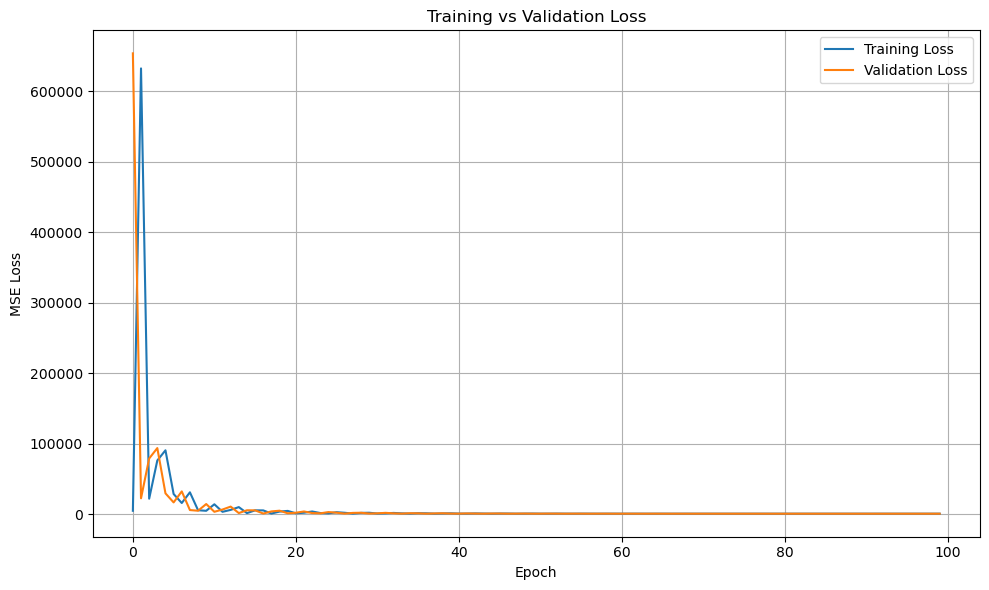

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [82]:
# Check for overlap between training and test edge pairs
overlap = set(map(tuple, train_edge_pairs.t().tolist())) & set(map(tuple, test_edge_pairs.t().tolist()))
print(f"Overlap between train/test edges: {len(overlap)}")

Overlap between train/test edges: 0


try to plot the r2 value of the epochs.
There might be an embedded loss function in graphSAGE to find and plot separately. Similar nodes should have value similar to each other, balance with the opposite of far = different value?

## **6. Evaluation parameters**

In [77]:
from sklearn.metrics import r2_score

# After model.eval() and predictions
model.eval()
with torch.no_grad():
    preds = model(data.x, data.edge_index, test_edge_pairs)
    test_loss = loss_fn(preds, test_y)
    r2 = r2_score(test_y.cpu().numpy(), preds.cpu().numpy())

    print(f"\nTest MSE: {test_loss.item():.4f}")
    print(f"Test R²: {r2:.4f}")



Test MSE: 810.8453
Test R²: 0.7801


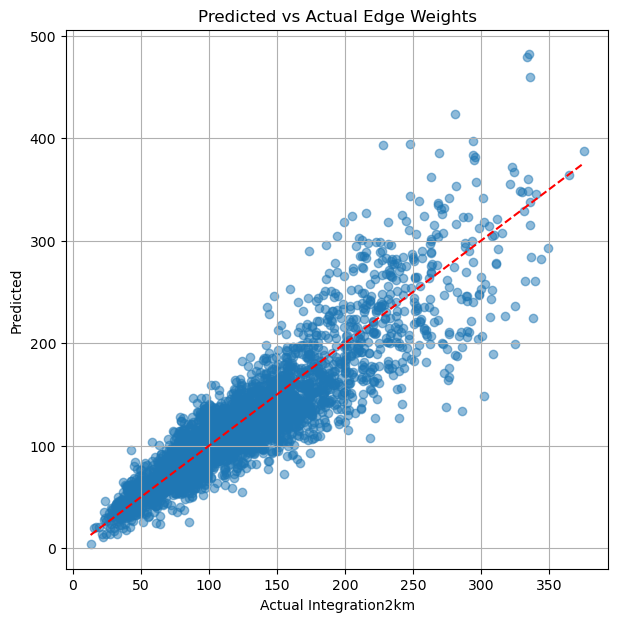

In [78]:
import matplotlib.pyplot as plt

# Ensure tensors are on CPU and converted to NumPy
actual = test_y.cpu().numpy()
predicted = preds.cpu().numpy()

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # y = x line
plt.xlabel('Actual Integration2km')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Edge Weights')
plt.grid(True)
plt.show()


## **7. Visualize predicted values on road network**

In [66]:
# Create a copy to avoid modifying original df
df_with_preds = df.copy()

# Initialize predicted column with NaNs
df_with_preds['predicted_integration'] = float('nan')

# Assign predictions to correct rows
df_with_preds.loc[test_idx, 'predicted_integration'] = preds.cpu().numpy()


In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def compare_predictions(dataframe, true_col, pred_col, geometry_col='geometry', crs='EPSG:27700'):
    gs = gpd.GeoSeries.from_wkt(dataframe[geometry_col])
    gdf = gpd.GeoDataFrame(dataframe, geometry=gs, crs=crs)

    vmin = min(gdf[true_col].min(), gdf[pred_col].min())
    vmax = max(gdf[true_col].max(), gdf[pred_col].max())
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    gdf.plot(column=true_col, cmap='viridis', legend=True, ax=axes[0], norm=norm)
    axes[0].set_title(f"True: {true_col}")
    axes[0].axis('off')

    gdf.plot(column=pred_col, cmap='viridis', legend=True, ax=axes[1], norm=norm)
    axes[1].set_title(f"Predicted: {pred_col}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



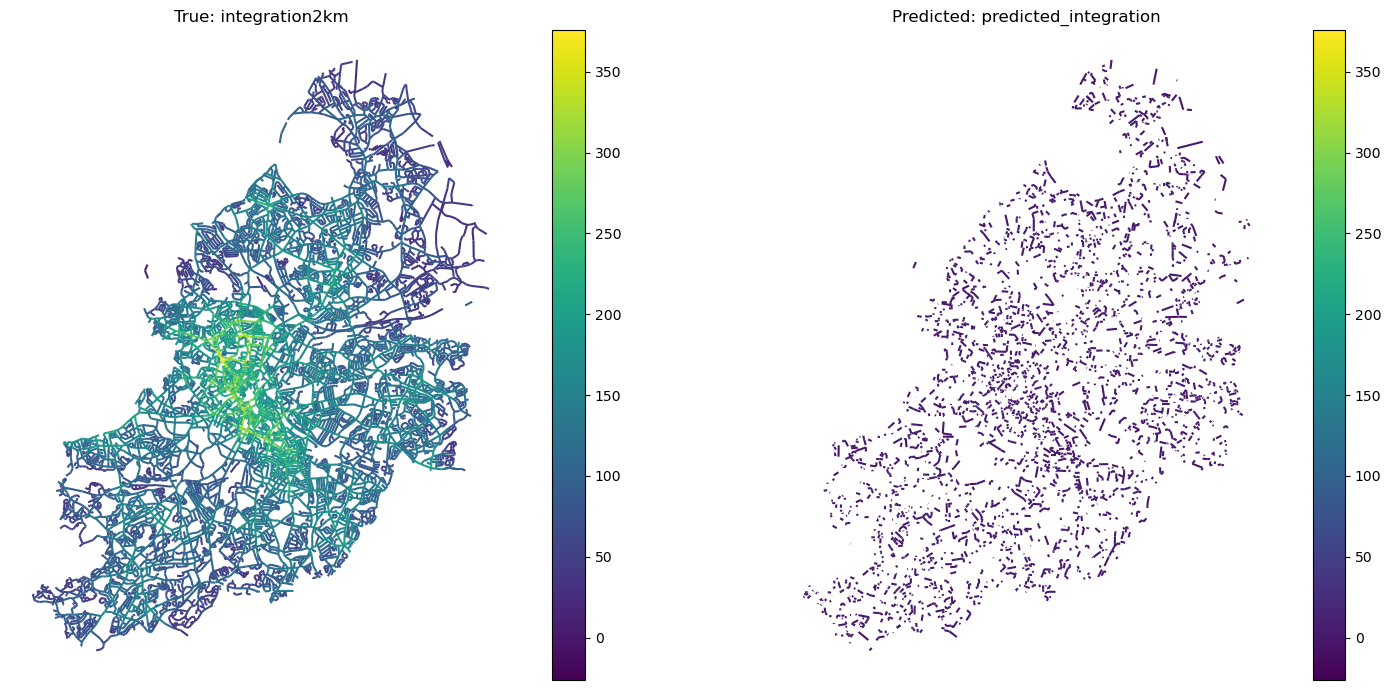

In [68]:
# just plot the test dataset first
compare_predictions(
    dataframe=df_with_preds,
    true_col='integration2km',
    pred_col='predicted_integration',
    geometry_col='geometry'  # or 'wkt' if needed
)

In [31]:
# Define path where you want to save the file
output_path = "birmingham_with_predictions.csv"  # change path as needed

# Save to CSV
df_with_preds.to_csv(output_path, index=False)

print(f"Saved with predictions to: {output_path}")

Saved with predictions to: birmingham_with_predictions.csv


## **8. Run & visualize predictions on the whole network**

In [32]:
model.eval()
with torch.no_grad():
    # Use all edges in the graph for prediction
    all_edge_pairs = df[['source_id', 'target_id']].values.T
    all_edge_pairs = torch.tensor(all_edge_pairs, dtype=torch.long)

    # Predict for all edges
    full_preds = model(data.x, data.edge_index, all_edge_pairs)

    test_loss = loss_fn(preds, test_y)
    r2 = r2_score(test_y.cpu().numpy(), preds.cpu().numpy())

    print(f"\nTest MSE: {test_loss.item():.4f}")
    print(f"Test R²: {r2:.4f}")



Test MSE: 797.2829
Test R²: 0.7837


In [33]:
df_with_preds_full = df.copy()
df_with_preds_full['predicted_integration'] = full_preds.cpu().numpy()

df_with_preds_full.to_csv("birmingham_full_predictions.csv", index=False)
print("Full network predictions saved to: birmingham_full_predictions.csv")


Full network predictions saved to: birmingham_full_predictions.csv


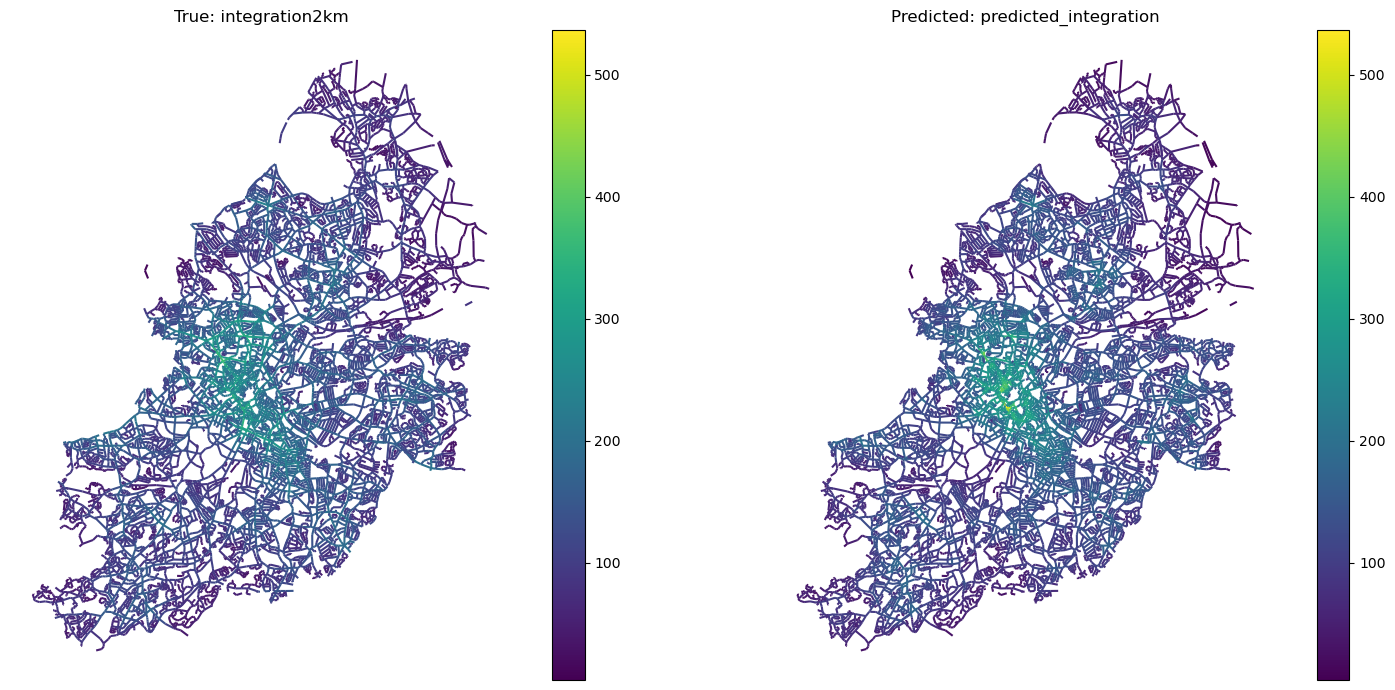

In [34]:
compare_predictions(
    dataframe=df_with_preds_full,
    true_col='integration2km',
    pred_col='predicted_integration',
    geometry_col='geometry'  # or 'wkt' if needed
)


Visualize Residuals

In [35]:
df_with_preds_full['residual'] = (
    df_with_preds_full['predicted_integration'] - df_with_preds_full['integration2km']
)

<Figure size 1200x800 with 0 Axes>

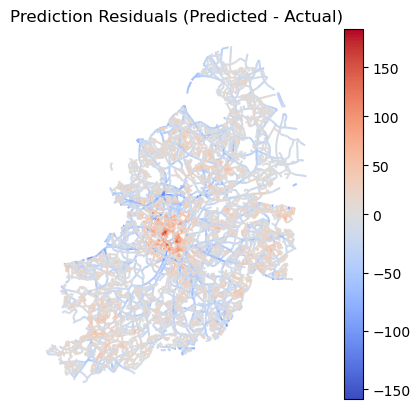

In [36]:
import geopandas as gpd
from matplotlib.colors import Normalize, TwoSlopeNorm

def plot_residuals(gdf, residual_col='residual', geometry_col='geometry', crs='EPSG:27700'):
    gs = gpd.GeoSeries.from_wkt(gdf[geometry_col]) if gdf[geometry_col].dtype == 'object' else gdf[geometry_col]
    gdf = gpd.GeoDataFrame(gdf, geometry=gs, crs=crs)

    # Use diverging color scale centered at 0
    vmin = gdf[residual_col].min()
    vmax = gdf[residual_col].max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    plt.figure(figsize=(12, 8))
    gdf.plot(column=residual_col, cmap='coolwarm', legend=True, norm=norm)
    plt.title("Prediction Residuals (Predicted - Actual)")
    plt.axis('off')
    plt.show()

# Call it
plot_residuals(df_with_preds_full)


## **9. Testing trained model on London's network**

In [83]:
new_df = pd.read_csv("Cambridge.csv")  # Replace with your file path

def extract_coords(linestring):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", linestring)
    coords = list(map(float, coords))
    return (coords[0], coords[1]), (coords[2], coords[3])

new_df['source_coords'], new_df['target_coords'] = zip(*new_df['geometry'].apply(extract_coords))

# Build unique node set
all_coords = pd.concat([new_df['source_coords'], new_df['target_coords']])
unique_coords = pd.Series(all_coords.unique())
coord_to_id = {coord: idx for idx, coord in enumerate(unique_coords)}

new_df['source_id'] = new_df['source_coords'].map(coord_to_id)
new_df['target_id'] = new_df['target_coords'].map(coord_to_id)


In [84]:
num_nodes = len(coord_to_id)
node_features = np.zeros(num_nodes)

for _, row in new_df.iterrows():
    node_features[row['source_id']] += row['nodecount2km']
    node_features[row['target_id']] += row['nodecount2km']

x_new = torch.tensor(node_features, dtype=torch.float).unsqueeze(1)


In [85]:
edge_index_new = torch.tensor(new_df[['source_id', 'target_id']].values.T, dtype=torch.long)

from torch_geometric.data import Data
data_new = Data(x=x_new, edge_index=edge_index_new)


In [86]:
model.eval()
with torch.no_grad():
    edge_pairs_new = edge_index_new  # all edges
    preds_new = model(data_new.x, data_new.edge_index, edge_pairs_new)


In [87]:
new_df['predicted_integration'] = preds_new.cpu().numpy()
new_df.to_csv("new_network_predictions.csv", index=False)


In [88]:
from sklearn.metrics import r2_score

# Check both predicted and actual values exist
if 'integration2km' in new_df.columns:
    actual_new = new_df['integration2km'].values
    predicted_new = new_df['predicted_integration'].values

    r2_new = r2_score(actual_new, predicted_new)
    print(f"R² on new dataset: {r2_new:.4f}")
else:
    print("No ground truth 'integration2km' found in new dataset.")


R² on new dataset: 0.7459


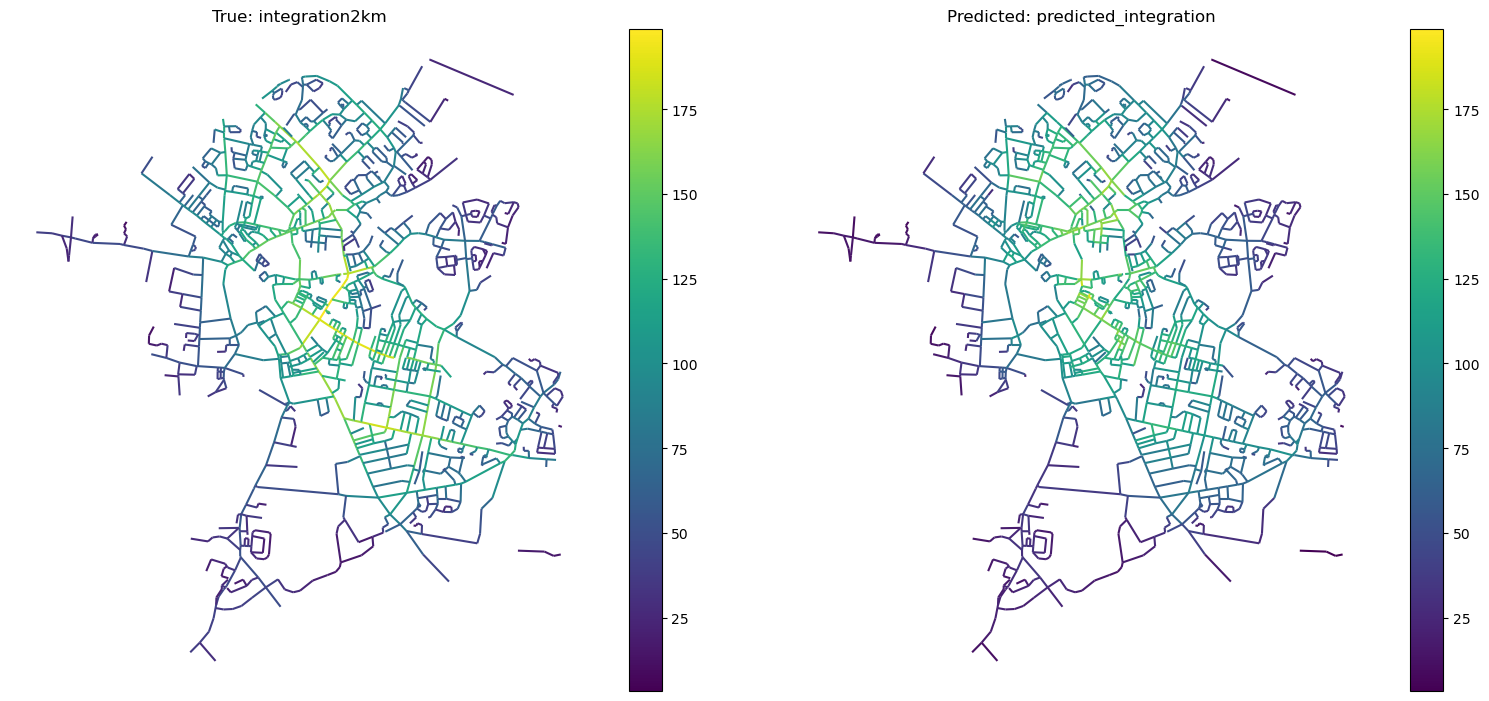

In [89]:
compare_predictions(
    dataframe=new_df,
    true_col='integration2km',
    pred_col='predicted_integration',
    geometry_col='geometry'  # or 'wkt' if needed
)


In [48]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure predictions and actual values exist
actual_london = new_df['integration2km'].values
predicted_london = new_df['predicted_integration'].values

mse_london = mean_squared_error(actual_london, predicted_london)
r2_london = r2_score(actual_london, predicted_london)

print(f"London MSE: {mse_london:.2f}")
print(f"London R²: {r2_london:.4f}")

London MSE: 14245.57
London R²: -2.0337


In [49]:
print("Birmingham integration range:", df_with_preds_full['integration2km'].describe())
print("London integration range:", new_df['integration2km'].describe())

print("Node feature (sum of nodecount2km) stats:")
print("  Birmingham:", x.mean().item(), x.std().item())
print("  London:", x_new.mean().item(), x_new.std().item())

Birmingham integration range: count    16192.000000
mean       127.033866
std         59.216205
min         12.623198
25%         85.124661
50%        118.185970
75%        158.399823
max        375.658881
Name: integration2km, dtype: float64
London integration range: count    754.000000
mean     366.414757
std       68.571501
min      170.124102
25%      323.553549
50%      366.559513
75%      415.769955
max      575.686887
Name: integration2km, dtype: float64
Node feature (sum of nodecount2km) stats:
  Birmingham: 1157.7418212890625 661.345703125
  London: 4445.93115234375 1349.6317138671875
